In [2]:
from Simworld import visualize_state,Hex
import numpy as np
import random
from IPython import display
import time

In [5]:
env = Hex(4)

(((1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)), 0, False)

((0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (0, 3),
 (1, 3),
 (2, 3),
 (3, 3))

Blue player won the game


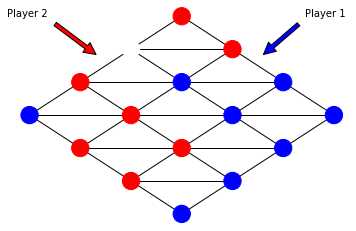

In [4]:
while not is_final:
        frame = visualize_state(env)
        display.clear_output(wait=True)
        display.display(frame)
        time.sleep(1)
        #Add SAP in case there are new states
        
        action = random.sample(action_list,1)[0]
        next_state,reward,is_final = env.step(action)
        state = next_state
display.clear_output(wait=True)
frame = visualize_state(env)
display.display(frame)


Blue player won the game


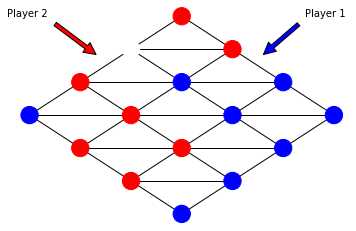

In [5]:
visualize_state(env)

In [6]:
env.board.cells[0][1].state = (1,0)

In [7]:
import copy
env2 = copy.deepcopy(env)

In [8]:
env.board.cells[0][2].state = (1,0)

In [9]:
cell = cells[0][0]
[neig for cell.neighboars.values() if neig.state == self.player]

SyntaxError: cannot assign to function call (<ipython-input-9-e8521bb021ab>, line 2)

In [ ]:
visualize_state(env2)

In [11]:
import random
import numpy as np
from graph import Node
from state import State, NimState
from mcts import *

state = NimState(None, 3, 7, True)
root_node = Node(state)
mtcs = MCTS(NimState)
tree = Tree(root_node)

leaf_node = mtcs.get_leaf_node(tree)

while not leaf_node.state.is_game_over():
    print(f'The node we are expanding is {leaf_node}')
    mtcs.expand_node(leaf_node)
    leaf_node = mtcs.get_leaf_node(tree)

winner = leaf_node.state.get_winner()
print(f'Game over, the winner is player {1 if winner else 2}')

NameError: name 'Tree' is not defined

In [12]:
for episode in 10:
    state = NimState(None, 3, 7, True)
    root_node = Node(state)
    mtcs = MCTS(NimState)
    tree = Tree(root_node)
    

TypeError: 'int' object is not iterable


1. is = save interval for ANET (the actor network) parameters
2. Clear Replay Buffer (RBUF)
3. Randomly initialize parameters (weights and biases) of ANET 
4. For ga in number actual games:

  (a) Initialize the actual game board (Ba) to an empty board.

  (b) sinit ← starting board state

  (c) Initialize the Monte Carlo Tree (MCT) to a single root, which represents sinit 
  
  (d) While Ba not in a final state:

    • Initialize Monte Carlo game board (Bmc) to same state as root. 

    • For gs in number search games:

      – Use tree policy Pt to search from root to a leaf (L) of MCT. Update Bmc with each move.

      – Use ANET to choose rollout actions from L to a final state (F). Update Bmc with each move. 

      – Perform MCTS backpropagation from F to root.

    • next gs

    • D = distribution of visit counts in MCT along all arcs emanating from root. 

    • Add case (root, D) to RBUF

    • Choose actual move (a*) based on D

    • Perform a* on root to produce successor state s*

    • Update Ba to s*

    • In MCT, retain subtree rooted at s*; discard everything else.

    • root←s*

  (e) Train ANET on a random minibatch of cases from RBUF 

  (f) if ga modulo is == 0:

• Save ANET’s current parameters for later use in tournament play. 5. next ga


In [43]:
import random
import numpy as np
from graph import Node
from state import State, NimState
from mcts import *
from ANET import ANET
from Simworld import visualize_state,Hex
from tqdm import tqdm
from IPython import display
import time
import math


In [44]:
#Training parameters
NUMBER_OF_GAMES = 100
GAME = Hex
STARTING_PLAYER_ID = 1
SIZE = 4
NUMBER_SEARCH_GAMES = 100
NUM_AGENTS = 3
BATCH_SIZE = 40

In [63]:
def select_batch(replay_buffer,batch_size,upper_percent=0.8,upper_fraq = 3/4):
    middle = math.ceil(len(replay_buffer)*upper_fraq)
    lower = replay_buffer[:middle]
    upper = replay_buffer[middle:]
    while batch_size*upper_percent>len(upper):
        batch_size=batch_size//2
    print(len(upper))
    print(batch_size*upper_percent)
    num_upper_batch = math.floor(batch_size*upper_percent)
    num_lower_batch = batch_size-num_upper_batch
    upper_batch = random.sample(upper,num_upper_batch)
    lower_batch = random.sample(lower,num_lower_batch)
    return lower_batch+upper_batch


In [64]:
action_space = Hex(SIZE).get_action_space()
anet = ANET(input_size=SIZE,output_size=len(action_space))

In [65]:
replay_buffer = []
for game in tqdm(range(NUMBER_OF_GAMES+1)):
    #Initialize environment
    env = Hex(SIZE,STARTING_PLAYER_ID)
    is_final = env.is_final()
    #Initialize mcts
    root = Node(env)
    board_mcts = MCTS(root, anet) 
    is_final = env.is_final()
    while not is_final:
        board_mcts.set_root(root)
        board_mcts.run_simulations(NUMBER_SEARCH_GAMES)
        D,new_root = board_mcts.get_probability_distribution(board_mcts.root,action_space)
        state = env.get_state()
        replay_buffer.append((state,D))
        action =action_space[np.argmax(D)]
        #Perform the action in the actual environment
        state,_,is_final = env.step(action)
        #Update root of MCST to be the choosen childstate
        root = new_root
        board_mcts.set_root(root)
    batch = select_batch(replay_buffer,BATCH_SIZE,)
    features = [replay[0] for replay in replay_buffer]
    labels = [replay[1] for replay in replay_buffer]
    anet.fit(features,labels)

    if game%(NUMBER_OF_GAMES//(NUM_AGENTS-1))==0:
        anet.save_anet(SIZE,game)
    

        
        
        

        
        



         

  1%|          | 1/101 [00:06<10:17,  6.17s/it]7
4.0
Model has been saved to models/4_ANET_level_0
  2%|▏         | 2/101 [00:09<07:28,  4.53s/it]10
8.0
  3%|▎         | 3/101 [00:13<07:13,  4.42s/it]14
8.0
  4%|▍         | 4/101 [00:18<07:25,  4.59s/it]19
16.0
  5%|▍         | 5/101 [00:26<09:00,  5.64s/it]25
16.0
  6%|▌         | 6/101 [00:32<09:31,  6.02s/it]30
16.0
  7%|▋         | 7/101 [00:39<09:48,  6.26s/it]35
32.0
  8%|▊         | 8/101 [00:43<08:41,  5.60s/it]39
32.0
  9%|▉         | 9/101 [00:47<07:50,  5.12s/it]44
32.0
 10%|▉         | 10/101 [00:52<07:34,  5.00s/it]49
32.0
 11%|█         | 11/101 [00:57<07:22,  4.91s/it]54
32.0
 12%|█▏        | 12/101 [01:01<07:04,  4.77s/it]58
32.0
 13%|█▎        | 13/101 [01:05<06:27,  4.40s/it]61
32.0
 14%|█▍        | 14/101 [01:08<05:53,  4.06s/it]66
32.0
 15%|█▍        | 15/101 [01:13<06:03,  4.23s/it]70
32.0
 16%|█▌        | 16/101 [01:16<05:42,  4.03s/it]74
32.0
 17%|█▋        | 17/101 [01:21<05:58,  4.26s/it]79
32.0
 18%|█▊        

In [66]:
from TOPP import TOPP

In [67]:
top = TOPP( SIZE, Hex, 1000, 100, 3)
wins = top.run_tournament()

Loaded model from models/4_ANET_level_0
Loaded model from models/4_ANET_level_50
Loaded model from models/4_ANET_level_100
[ANET(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=17, out_features=60, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=60, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=20, bias=True)
    (6): ReLU()
    (7): Linear(in_features=20, out_features=16, bias=True)
    (8): Softmax(dim=-1)
  )
  (loss_function): BCELoss()
), ANET(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=17, out_features=60, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=60, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=20, bias=True)
    (6): ReLU()
    (7): Linear(in_features=20, out_features=16, bias=True)
    (8): Softmax(dim=-1)
  )
  (loss_function):

<AxesSubplot:>

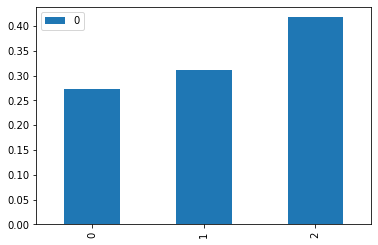

In [68]:
import pandas as pd
df = pd.DataFrame(wins)
norm = df/df[0].sum()
norm.plot.bar()

In [18]:
action_space = Hex(SIZE,STARTING_PLAYER_ID).get_action_space()
anet = ANET(input_size=SIZE,output_size=len(action_space))
anet.load_anet(SIZE,200)

RuntimeError: Error(s) in loading state_dict for ANET:
	Missing key(s) in state_dict: "model.7.weight", "model.7.bias". 
	size mismatch for model.5.weight: copying a param with shape torch.Size([16, 30]) from checkpoint, the shape in current model is torch.Size([20, 30]).
	size mismatch for model.5.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([20]).

In [13]:
test_games = 100000
visualize = False
winner = []

for game in range(test_games):
    #if game==test_games-1:
     #   visualize=True
    
    env = Hex(SIZE,1)
    is_final = env.is_final()
    while not is_final:
            if visualize:
                frame = visualize_state(env)
                display.clear_output(wait=True)
                display.display(frame)
                time.sleep(1)
            action_list = env.legal_actions()
            if env.player==1:
                state = env.get_state()
                _,action_index = anet.get_move(state)
                action = action_space[action_index]
            else:
                action = random.sample(action_list,1)[0]
            next_state,reward,is_final = env.step(action)
            state = next_state
    if visualize:
        display.clear_output(wait=True)
        frame = visualize_state(env)
        display.display(frame)
    winner.append(env.player)



KeyboardInterrupt: 

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(winner)
df.value_counts(normalize=True).plot.bar()



In [47]:
anet.save_anet(SIZE,NUMBER_OF_GAMES)

Model has been saved to models/4_ANET_level_200


In [6]:
board_state = s_init.board
player = s_init.player
state = np.insert(board_state,0,player)


In [21]:
anet2 = ANET(input_size=SIZE,output_size=len(action_space))
anet2.load_anet(SIZE,10)

Loaded model from models/4_ANET_level_10


In [12]:
anet.get_move(state)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 2x60)

In [16]:
import torch


tensor([1., 9.])

{0: 1, 1: 2, 2: 3, 3: 4}

In [9]:
D = np.zeros(len(action_space))

In [18]:
[1,2,3,4]+[5,7,8,9]

[1, 2, 3, 4, 5, 7, 8, 9]

In [1]:
env.get_action_space()

NameError: name 'env' is not defined